# MRR Implementation

In [3]:
!pip3 install numpy
!pip3 install numba
!pip3 install pandas

import numpy as np
import numba as nb
np.random.seed(2)

def generate_subsample(top_k: int, users_count: int, gt_count: int = 3):
  users = np.arange(0, users_count)
  user_to_many_records = np.repeat(users, gt_count)
  np.random.shuffle(user_to_many_records)
  targets = np.stack([user_to_many_records,
                      np.random.randint(0, 50, len(user_to_many_records))])
  predicts = np.random.randint(0, 50, (users_count, top_k))

  assert len(predicts) == len(users)
  assert len(np.unique(targets[0, :]) == len(predicts))
  
  return users, targets, predicts


     |████████████████████████████████| 17.1 MB 10.8 MB/s            
You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 3.5 MB 1.6 MB/s            
     |████████████████████████████████| 34.6 MB 115 kB/s             
You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 12.1 MB 12.2 MB/s            
  Using cached pytz-2022.6-py2.py3-none-any.whl (498 kB)
You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
users, targets, predicts = generate_subsample(10, 100)

## Naive

In [5]:
def naive_mrr(users, targets, predicts):
  
  per_user_mrr = np.zeros(users.shape[0])

  for user in users:
    user_targets = targets[1, :][targets[0, :] == user]
    predict_positions = np.ones(user_targets.shape[0]) * predicts[0].shape[0]

    for target_idx, user_target in enumerate(user_targets):
      positional_idxes = np.where(predicts[user] == user_target)[0]

      if (len(positional_idxes) != 0):
        predict_positions[target_idx] = positional_idxes.min()

    best_position = predict_positions.min()

    if best_position == predicts[0].shape[0]:
      per_user_mrr[user] = 0
    else:
      per_user_mrr[user] =  1 / (best_position + 1)
      
  return per_user_mrr.mean()

In [6]:
naive_mrr(users, targets, predicts)

0.14945238095238095

In [7]:
%time naive_mrr(users, targets, predicts)

CPU times: user 4.83 ms, sys: 4.63 ms, total: 9.46 ms
Wall time: 8.8 ms


0.14945238095238095

## Numba

In [8]:
@nb.njit(cache=True, parallel=True, nopython=True, fastmath=True)
def numba_mrr(users, targets, predicts):
  
  per_user_mrr = np.zeros(users.shape[0])

  for user in nb.prange(users.shape[0]):
    user_targets = targets[1, :][targets[0, :] == user]
    predict_positions = np.ones(user_targets.shape[0]) * predicts[0].shape[0]
  
    for target_idx, user_target in enumerate(user_targets):
      positional_idxes = np.where(predicts[user] == user_target)[0]

      if positional_idxes.shape[0] != 0:
        predict_positions[target_idx] = positional_idxes.min()

    best_position = predict_positions.min()

    if best_position == predicts[0].shape[0]:
      per_user_mrr[user] = 0
    else:
      per_user_mrr[user] =  1 / (best_position + 1)
      
  return per_user_mrr.mean()

/home/evgenii/repos/ed/RecoServiceTeam30/venv/lib/python3.10/site-packages/numba/core/decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [9]:
# pre compile
numba_mrr(users[:10], targets[:10], predicts[:10])

0.16499999999999998

In [10]:
%time numba_mrr(users, targets, predicts)

CPU times: user 54.1 ms, sys: 0 ns, total: 54.1 ms
Wall time: 5.2 ms


0.14945238095238095

## Pandas

In [11]:
import pandas as pd

In [12]:
def pandas_mrr(targets, predicts):
  
  # preprocess data
  df = pd.DataFrame(data={"Users": targets[0], "item": targets[1]})

  predicted_users = np.repeat(list(range(0, len(np.unique(targets[0])))),
                              predicts.shape[1])
  
  predicts = pd.DataFrame(data={"Users": predicted_users, 
                                "item": predicts.ravel()})
  
  # logic
  predicts["position"] = predicts.groupby("Users")["Users"].rank(method='first')
  df_recs = df.merge(predicts, how='left')
  metric = (1 / df_recs.groupby("Users")["position"].min()).fillna(0)

  return metric.mean()


In [13]:
%time pandas_mrr(targets, predicts)

CPU times: user 12.8 ms, sys: 115 µs, total: 13 ms
Wall time: 12 ms


0.14945238095238095

# Validate

In [15]:
!pip3 install matplotlib
import matplotlib.pyplot as plt
import time

  Using cached matplotlib-3.6.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached Pillow-9.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (296 kB)
  Using cached kiwisolver-1.4.4-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
You should consider upgrading via the '/home/evgenii/repos/ed/RecoServiceTeam30/venv/bin/python -m pip install --upgrade pip' command.


In [19]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100, 1000]

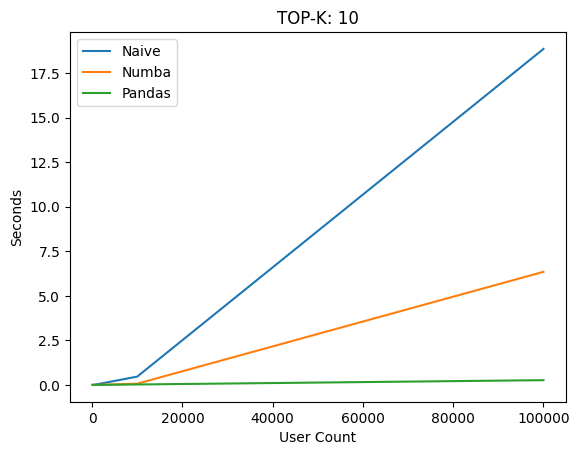

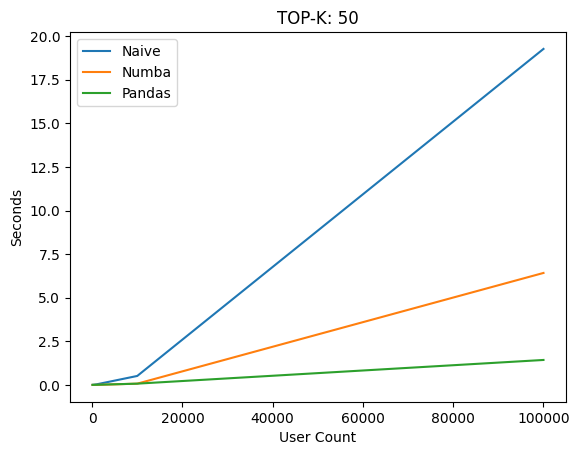

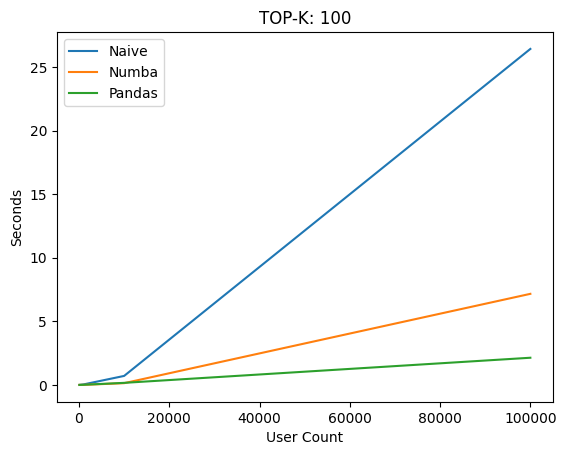

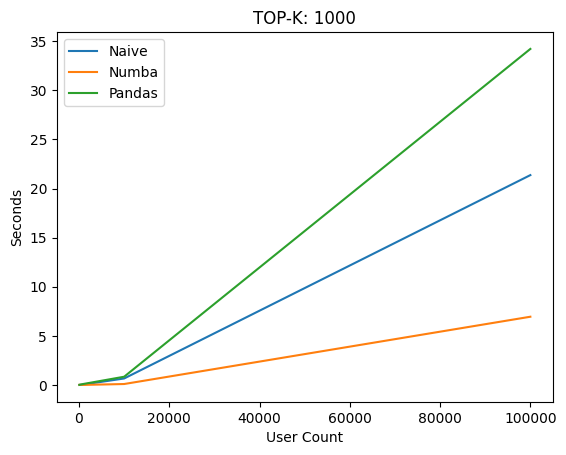

In [20]:
for k in top_k:
  naive_times = []
  numba_times = []
  pandas_times = []
  for user_count in users_count:
     users, targets, predicts = generate_subsample(k, user_count)
     # naive
     start = time.time()
     naive_mrr(users, targets, predicts)
     naive_times.append(time.time() - start)
     # numba
     start = time.time()
     numba_mrr(users, targets, predicts)
     numba_times.append(time.time() - start)
     # pandas
     start = time.time()
     pandas_mrr(targets, predicts)
     pandas_times.append(time.time() - start)
  plt.plot(users_count, naive_times, label="Naive")
  plt.plot(users_count, numba_times, label="Numba")
  plt.plot(users_count, pandas_times, label="Pandas")
  plt.legend()
  plt.xlabel("User Count")
  plt.ylabel("Seconds")
  plt.title(f"TOP-K: {k}")

  plt.show()
